In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import get_DAX

In [5]:
hist= get_DAX.get()
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5,lag_ret1,lag_ret2,lag_ret3,lag_ret4,lag_ret5
Date,,,,,,,,,,,,,,,,,
1988-01-08 00:00:00+01:00,1026.689941,1026.689941,1026.689941,1026.689941,0,0.0,0.0,1.197370,2.034796,3.024763,7.082493,2.116340,1014.469971,1006.010010,996.099976,956.489990,1005.190002
1988-01-11 00:00:00+01:00,987.520020,987.520020,987.520020,987.520020,0,0.0,0.0,-3.889849,-2.692479,-1.855053,-0.865086,3.192645,1026.689941,1014.469971,1006.010010,996.099976,956.489990
1988-01-12 00:00:00+01:00,986.890015,986.890015,986.890015,986.890015,0,0.0,0.0,-0.063817,-3.953666,-2.756296,-1.918870,-0.928903,987.520020,1026.689941,1014.469971,1006.010010,996.099976
1988-01-13 00:00:00+01:00,965.770020,965.770020,965.770020,965.770020,0,0.0,0.0,-2.163287,-2.227104,-6.116953,-4.919583,-4.082157,986.890015,987.520020,1026.689941,1014.469971,1006.010010
1988-01-14 00:00:00+01:00,974.460022,974.460022,974.460022,974.460022,0,0.0,0.0,0.895776,-1.267511,-1.331328,-5.221176,-4.023806,965.770020,986.890015,987.520020,1026.689941,1014.469971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13 00:00:00+01:00,15285.120117,15346.790039,15252.269531,15345.000000,65170400,0.0,0.0,0.723434,-0.049125,0.754881,1.261494,1.371568,15234.389648,15352.540039,15229.599609,15152.639648,15135.969727
2023-11-14 00:00:00+01:00,15358.589844,15632.440430,15337.599609,15614.429688,98894400,0.0,0.0,1.740578,2.464012,1.691453,2.495459,3.002072,15345.000000,15234.389648,15352.540039,15229.599609,15152.639648
2023-11-15 00:00:00+01:00,15631.669922,15759.839844,15628.190430,15748.169922,91670700,0.0,0.0,0.852870,2.593448,3.316881,2.544323,3.348329,15614.429688,15345.000000,15234.389648,15352.540039,15229.599609


In [6]:
#quantile levels
tau = [.025, .25, .5, .75, .975]

In [7]:
#define prediction array
#cols are quantile levels, rows are horizons
pred_baseline = np.zeros((5,5))

In [8]:
last_t = 1000

for i in range(5):
    ret_str = "ret"+str(i+1)
    
    pred_baseline[i,:] = np.quantile(hist[ret_str].iloc[-last_t:], q=tau)

Visualize the results

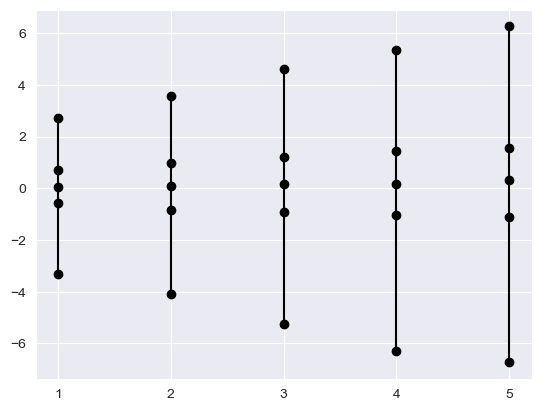

In [9]:
x = np.arange(5)+1
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

Create Submission DataFrame

In [10]:
df_sub = pd.DataFrame({
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1,2,5,6,7)],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,DAX,1 day,-3.321265,-0.551383,0.060969,0.720873,2.719772
1,DAX,2 day,-4.087895,-0.823250,0.072355,0.987420,3.570492
2,DAX,5 day,-5.259161,-0.917655,0.161798,1.224285,4.628697
3,DAX,6 day,-6.282629,-1.044070,0.186070,1.440815,5.367396
4,DAX,7 day,-6.735742,-1.091646,0.326190,1.573729,6.259934


In [11]:
from datetime import datetime
date_str = datetime.today().strftime('%Y%m%d')

In [12]:
#need to change this
PATH = "./"

df_sub.to_csv(PATH+"/"+date_str+"DAX_benchmark.csv")

In [15]:
from models.DAX import DAX_baseline

In [16]:
df=DAX_baseline.Dax_baseline(daxdata=hist)

AttributeError: module 'models.DAX.DAX_baseline' has no attribute 'Dax_baseline'